In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trained-models/Trained_Models/Bi-LSTMModel.pkl
/kaggle/input/trained-models/Trained_Models/LSTMModel.pkl
/kaggle/input/trained-models/Trained_Models/Bi-GRUModel.pkl
/kaggle/input/trained-models/Trained_Models/GRUModel.pkl
/kaggle/input/individealdatas/individual_csv_files/UDP_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/NTP_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/UdpLag_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/SNMP_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/MSSQL_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/LDAP_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/TFTP_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/Syn_Dataset_Random_Undersampled.csv
/kaggle/input/individealdatas/individual_csv_files/DNS_Datas

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('/kaggle/input/undersampledrenn/Repeated_Edited_Nearest_Neighbors_Under-sampled_Dataset.csv')
df = df[df['Label'] != 'BENIGN']

# Structure for GRU

In [1]:
import tensorflow as tf

print(tf.__version__)


2.9.2


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, LayerNormalization
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam

# Extract the features and label
features = df.drop("Label", axis=1).values
labels = df["Label"].values

# Encode the labels to numeric values
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = np_utils.to_categorical(labels)

# Define the number of folds for stratified K-fold cross-validation
k_folds = 2

# Define the GRU model
model = Sequential()
model.add(GRU(units=32, input_shape=(features.shape[1], 1), return_sequences=True))
model.add(GRU(units=32))
model.add(LayerNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=labels.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []
history_Array=[]
# Perform stratified K-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(skf.split(features, labels.argmax(1))):
    print("Fold", i+1)

    # Split the data into training and testing sets
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Reshape the data for RNN
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Train the model
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    history_Array.append(history)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train, y_train)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

print("Average Training Accuracy: {}".format(np.mean(train_acc_list)))
print("Average Training Loss: {}".format(np.mean(train_loss_list)))
print("Average Testing Accuracy: {}".format(np.mean(test_acc_list)))
print("Average Testing Loss: {}".format(np.mean(test_loss_list)))

Fold 1
3125/3125 [==============================] - 34s 11ms/step - loss: 0.2748 - accuracy: 0.8985
Fold 2
3125/3125 [==============================] - 34s 11ms/step - loss: 0.2302 - accuracy: 0.9099
Average Training Accuracy: 0.9040025174617767
Average Training Loss: 0.2513595223426819
Average Testing Accuracy: 0.9042475521564484
Average Testing Loss: 0.2524980828166008


# Model Summary

In [5]:
from keras.models import load_model

# assume that you have already defined and trained your model

# save the model to an HDF5 file with a .h5 extension
model.save('lstm_model.h5')



In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 42, 32)            3360      
                                                                 
 gru_9 (GRU)                 (None, 32)                6336      
                                                                 
 layer_normalization_3 (Laye  (None, 32)               64        
 rNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 11)                187       
                                                      

# Validation & Accuracy

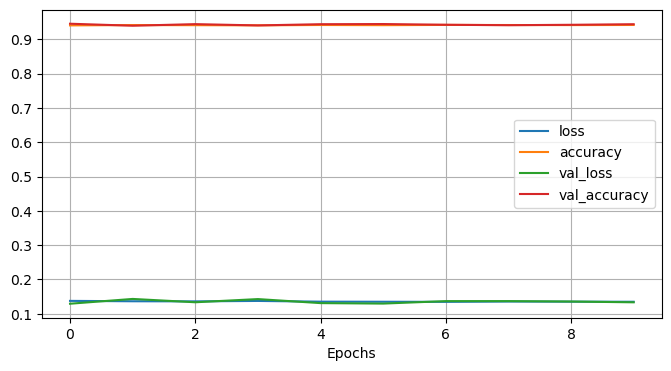

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

#pd.DataFrame(history_Array[len(history_Array)-1].history).plot(figsize=(8,4))
pd.DataFrame(history_Array[3].history).plot(figsize=(8,4))
plt.grid(True)
plt.gca()
plt.xlabel('Epochs')
plt.show()

# Export Model

In [29]:
import joblib
joblib.dump(value = model, filename = '/kaggle/working/GRUModel.pkl')

['/kaggle/working/GRUModel.pkl']

# Heat Map

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop("Label", axis=1).values
y = df["Label"].values
class_names = np.unique(y)
lb = LabelEncoder()
y = lb.fit_transform(y)
print(np.unique(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [74]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
y_classes

1250/1250 [==============================] - 5s 4ms/step


array([10, 10,  6, ...,  5,  4, 10])

In [75]:
import tensorflow as tf

confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

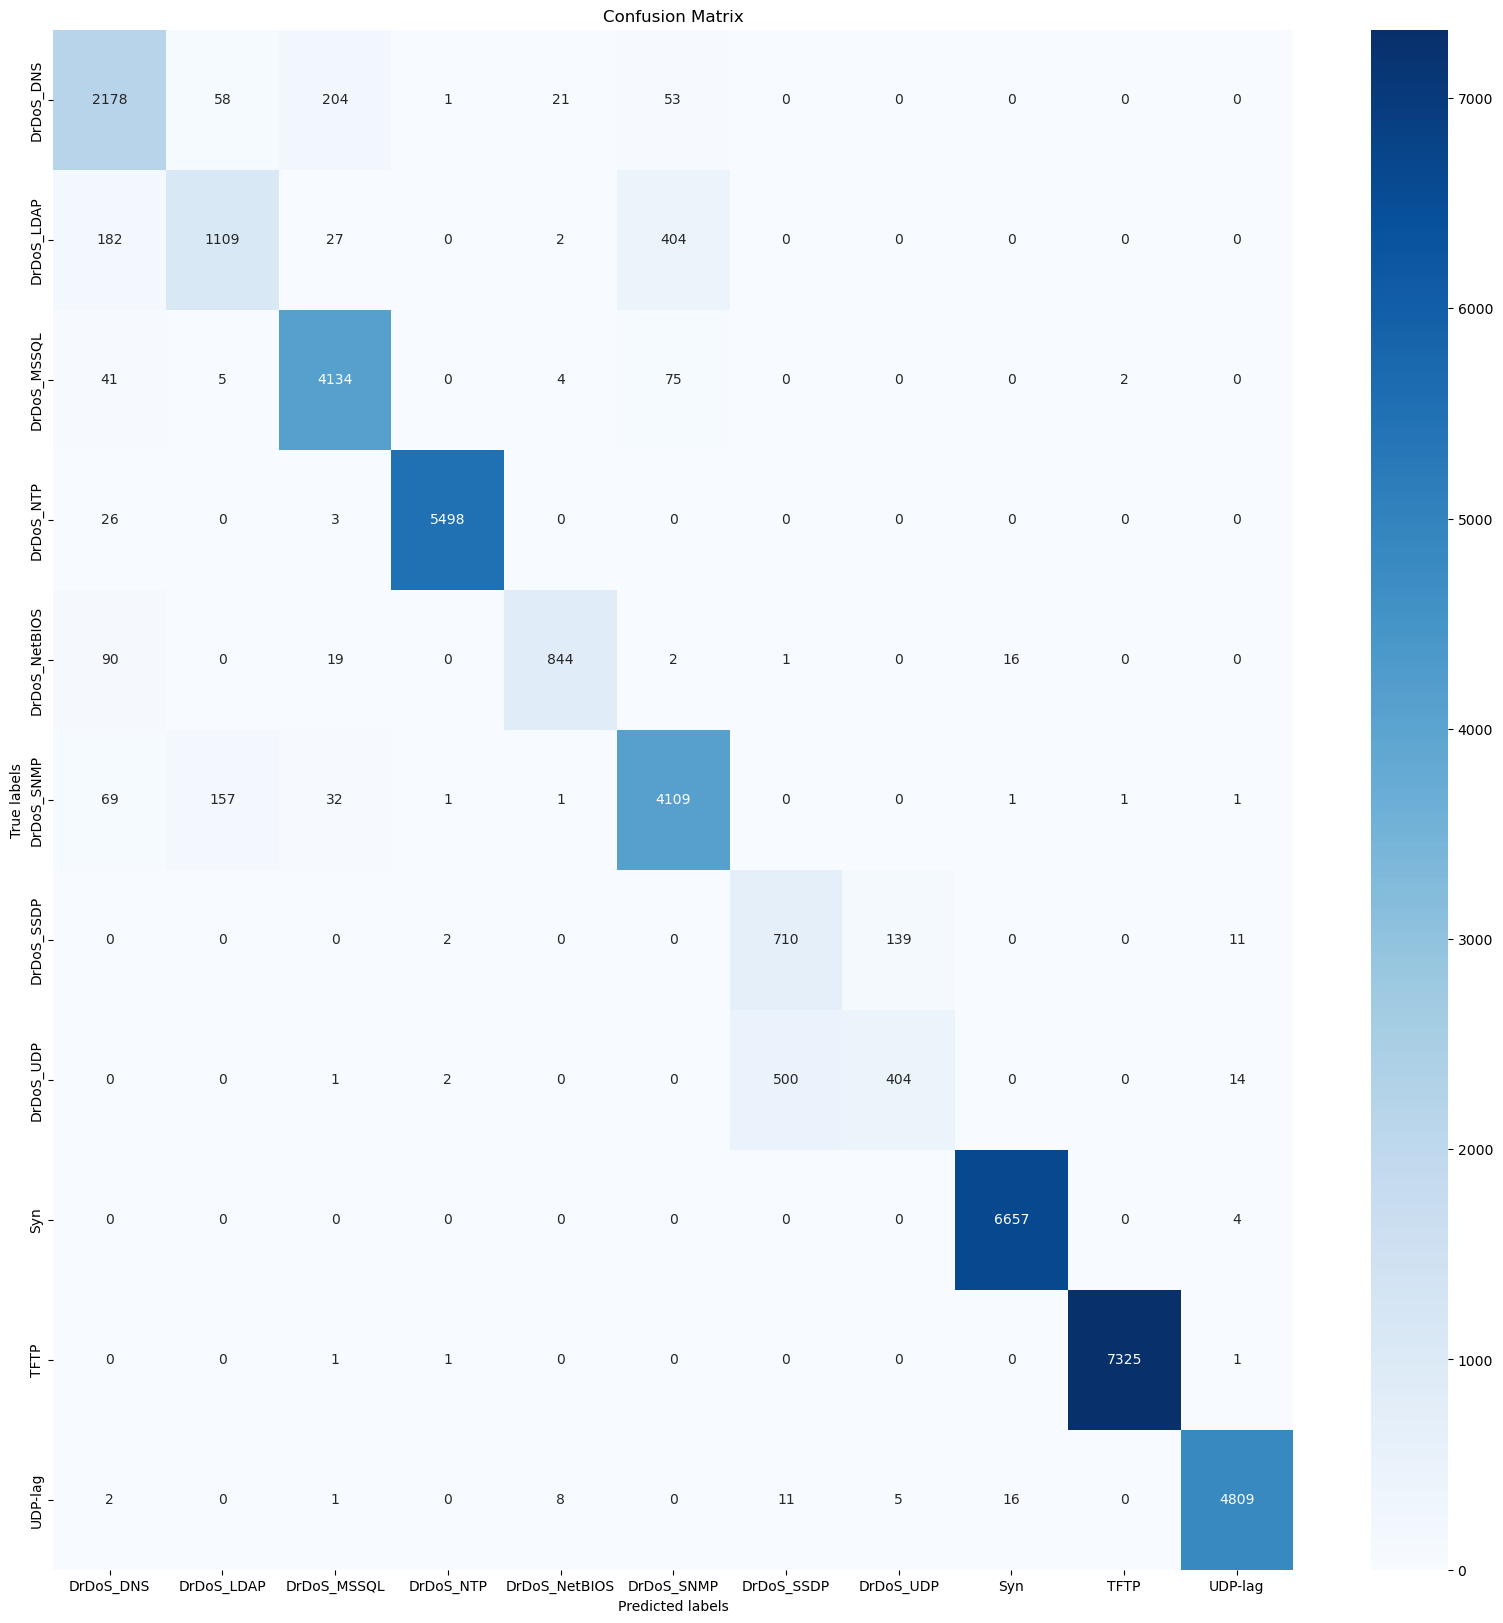

In [76]:
import seaborn as sb    

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names) 
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(20, 20)


plt.show()

# LSTM Model

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam



# Extract the features and label
features = df.drop("Label", axis=1).values
labels = df["Label"].values

# Encode the labels to numeric values
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

# Define the number of folds
n_splits = 2

# Initialize lists to store results
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []
history_Array=[]


# Define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(features.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(labels.shape[1], activation="softmax"))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Split the data into training and testing sets
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(features,labels.argmax(1)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Reshape the data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Train the model
    history = model.fit(X_train, y_train, epochs=1, batch_size=256, validation_data=(X_test, y_test), verbose=1)

    history_Array.append(history)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train, y_train)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

print("Average Training Accuracy: {}".format(np.mean(train_acc_list)))
print("Average Training Loss: {}".format(np.mean(train_loss_list)))
print("Average Testing Accuracy: {}".format(np.mean(test_acc_list)))
print("Average Testing Loss: {}".format(np.mean(test_loss_list)))

3125/3125 [==============================] - 69s 22ms/step - loss: 0.2017 - accuracy: 0.9173
Average Training Accuracy: 0.9134087264537811
Average Training Loss: 0.21725089848041534
Average Testing Accuracy: 0.9131137132644653
Average Testing Loss: 0.21789149194955826


In [9]:
from keras.models import load_model

# assume that you have already defined and trained your model

# save the model to an HDF5 file with a .h5 extension
model.save('lstm_model.h5')

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 42, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 11)                1111      
                                                                 
Total params: 122,311
Trainable params: 122,311
Non-trainable params: 0
_________________________________________________________________


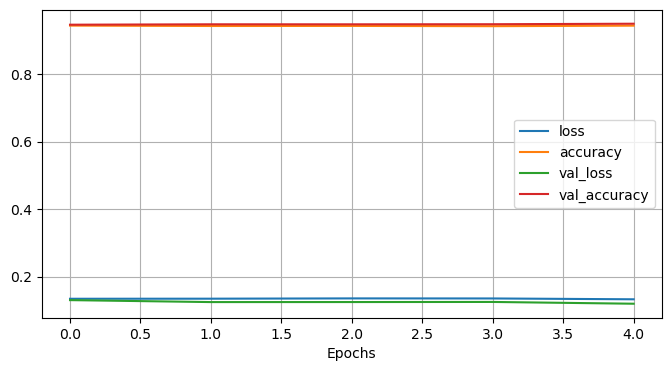

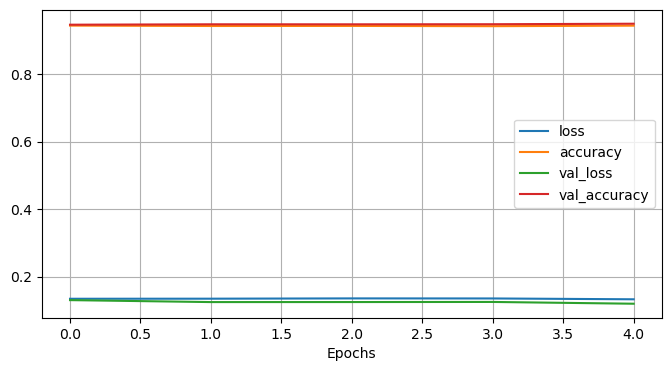

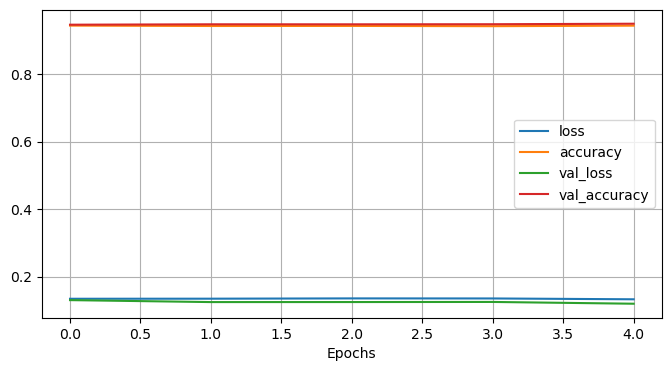

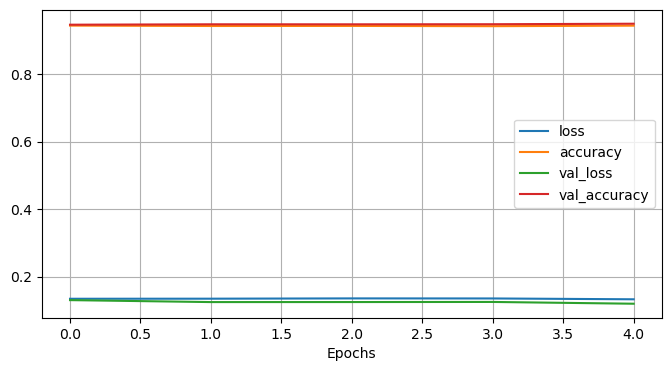

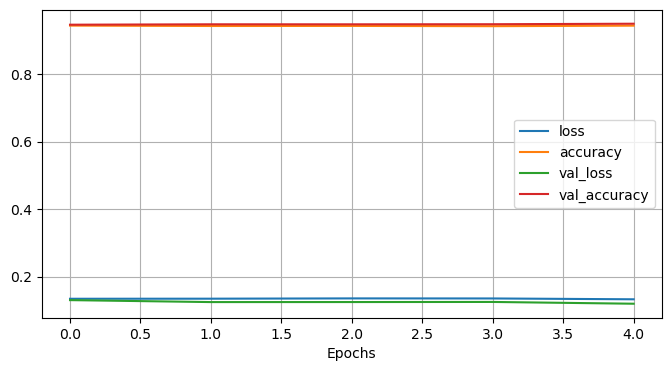

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

#pd.DataFrame(history_Array[len(history_Array)-1].history).plot(figsize=(8,4))
for i in range(5):
    pd.DataFrame(history_Array[3].history).plot(figsize=(8,4))
    plt.grid(True)
    plt.gca()
    plt.xlabel('Epochs')
    plt.show()

In [84]:
import joblib
joblib.dump(value = model, filename = '/kaggle/working/LSTMModel.pkl')

['/kaggle/working/LSTMModel.pkl']

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop("Label", axis=1).values
y = df["Label"].values
class_names = np.unique(y)
lb = LabelEncoder()
y = lb.fit_transform(y)
print(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [89]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
y_classes

1250/1250 [==============================] - 5s 4ms/step


array([10, 10,  6, ...,  5,  4, 10])

In [90]:
import tensorflow as tf

confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

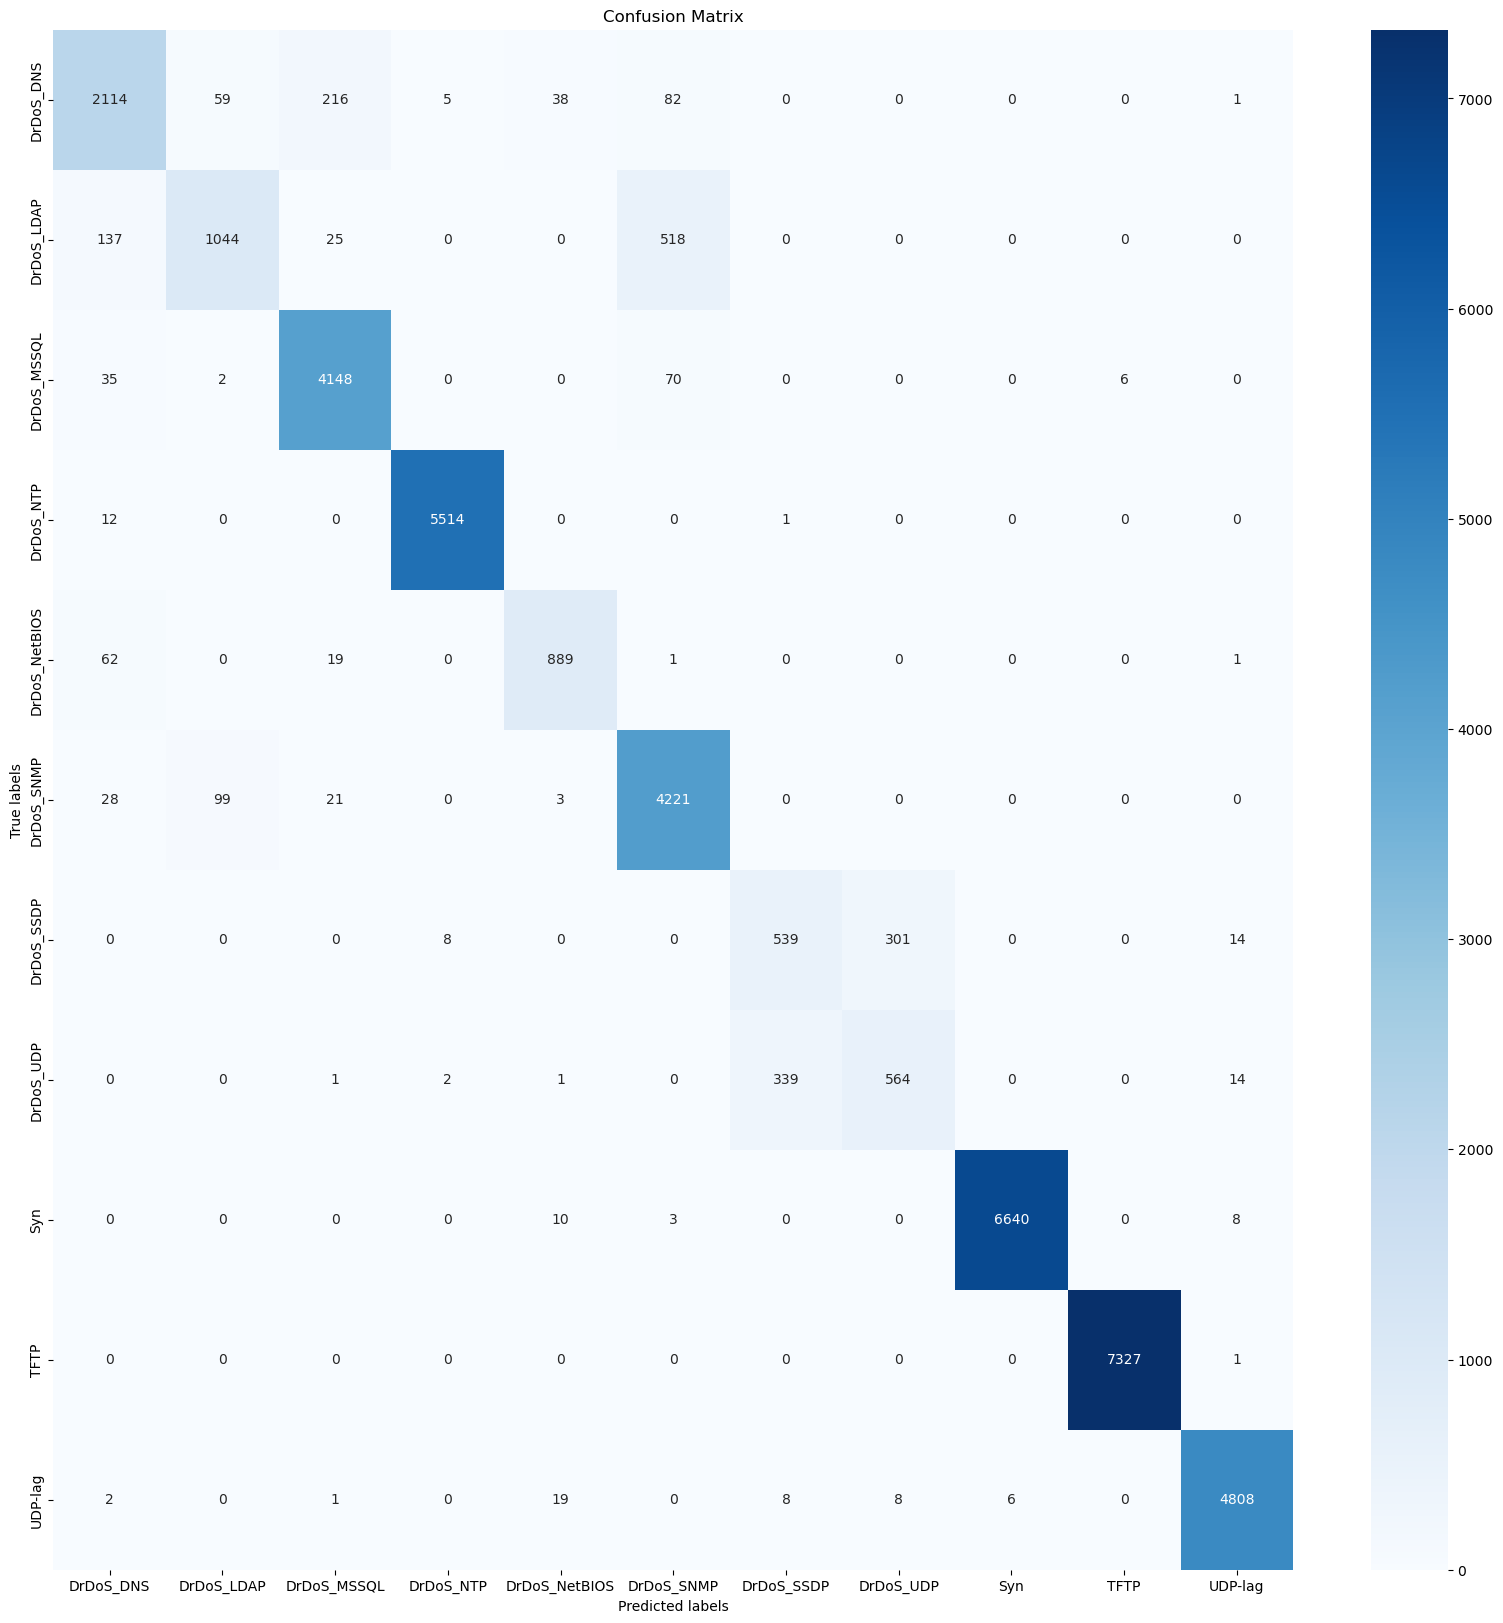

In [91]:
import seaborn as sb    

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names) 
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(20, 20)


plt.show()

# BiGRU Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Extract the features and label
features = df.drop("Label", axis=1).values
labels = df["Label"].values

# Encode the labels to numeric values
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

# Define the number of folds
n_splits = 2

# Initialize lists to store results
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []
history_Array=[]

model = tf.keras.Sequential()
# Add the first GRU layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64, return_sequences=True), input_shape=(features.shape[1], 1)))
# Add a dropout layer to prevent overfitting
model.add(tf.keras.layers.Dropout(0.5))
# Add the second GRU layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=32)))
# Add a dropout layer to prevent overfitting
model.add(tf.keras.layers.Dropout(0.5))

# Add a dense layer for the output
model.add(tf.keras.layers.Dense(units=labels.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# Split the data into training and testing sets
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(features,labels.argmax(1)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Reshape the data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Train the model
    history = model.fit(X_train, y_train, epochs=1, batch_size=256, validation_data=(X_test, y_test), verbose=1)

    history_Array.append(history)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train, y_train)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

print("Average Training Accuracy: {}".format(np.mean(train_acc_list)))
print("Average Training Loss: {}".format(np.mean(train_loss_list)))
print("Average Testing Accuracy: {}".format(np.mean(test_acc_list)))
print("Average Testing Loss: {}".format(np.mean(test_loss_list)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 42, 128)          25728     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 42, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 11)                715       
                                                                 
Total params: 57,547
Trainable params: 57,547
Non-trai

In [ ]:
from keras.models import load_model

# assume that you have already defined and trained your model

# save the model to an HDF5 file with a .h5 extension
model.save('bigru_model.h5')

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 42, 128)          25728     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 11)                715       
                                                                 
Total params: 57,547
Trainable params: 57,547
Non-traina

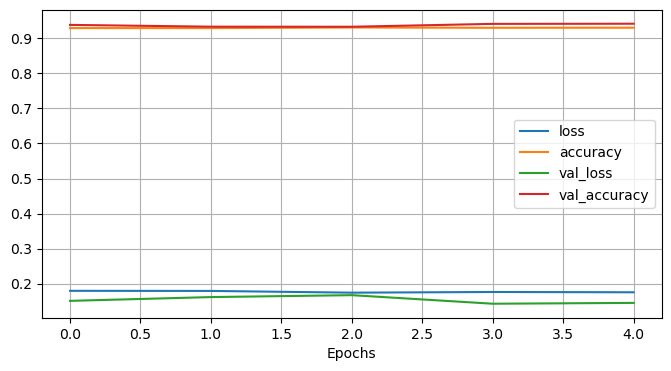

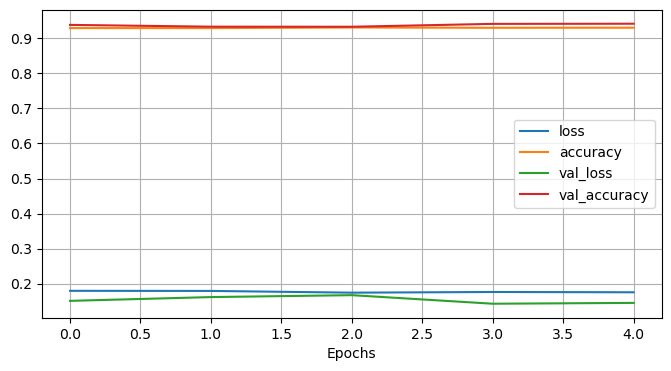

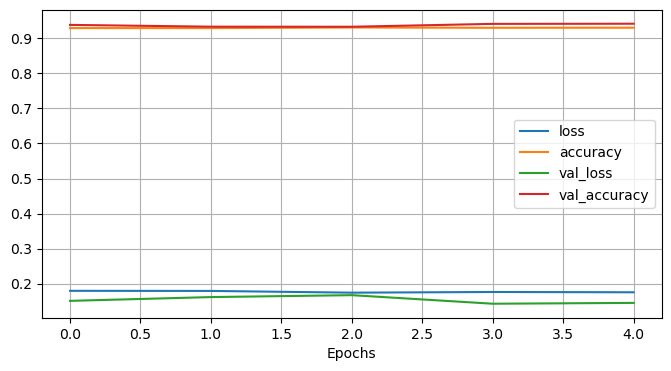

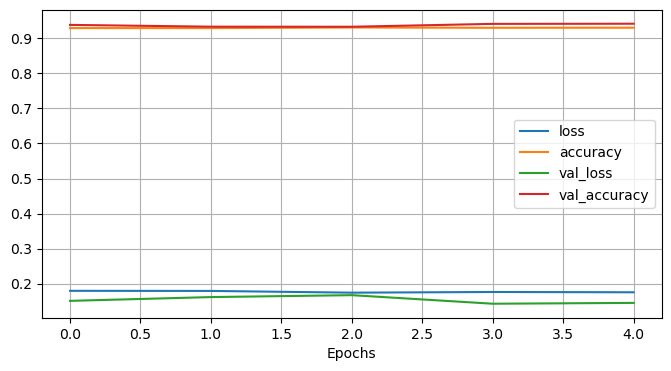

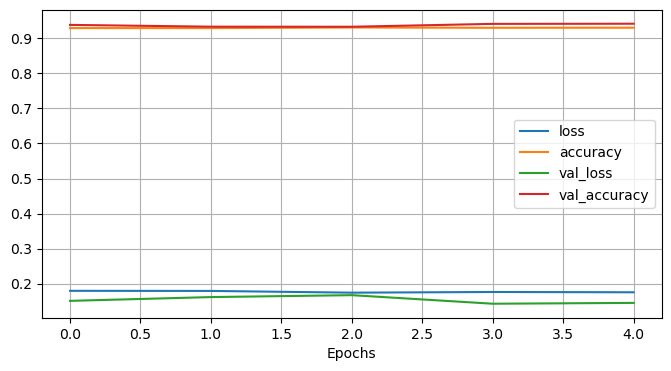

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

#pd.DataFrame(history_Array[len(history_Array)-1].history).plot(figsize=(8,4))
for i in range(5):
    pd.DataFrame(history_Array[3].history).plot(figsize=(8,4))
    plt.grid(True)
    plt.gca()
    plt.xlabel('Epochs')
    plt.show()

In [7]:
import joblib
joblib.dump(value = model, filename = '/kaggle/working/Bi-GRUModel.pkl')

['/kaggle/working/Bi-GRUModel.pkl']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop("Label", axis=1).values
y = df["Label"].values
class_names = np.unique(y)
lb = LabelEncoder()
y = lb.fit_transform(y)
print(np.unique(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [10]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
y_classes

1250/1250 [==============================] - 7s 5ms/step


array([10, 10,  6, ...,  5,  4, 10])

In [11]:
import tensorflow as tf

confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

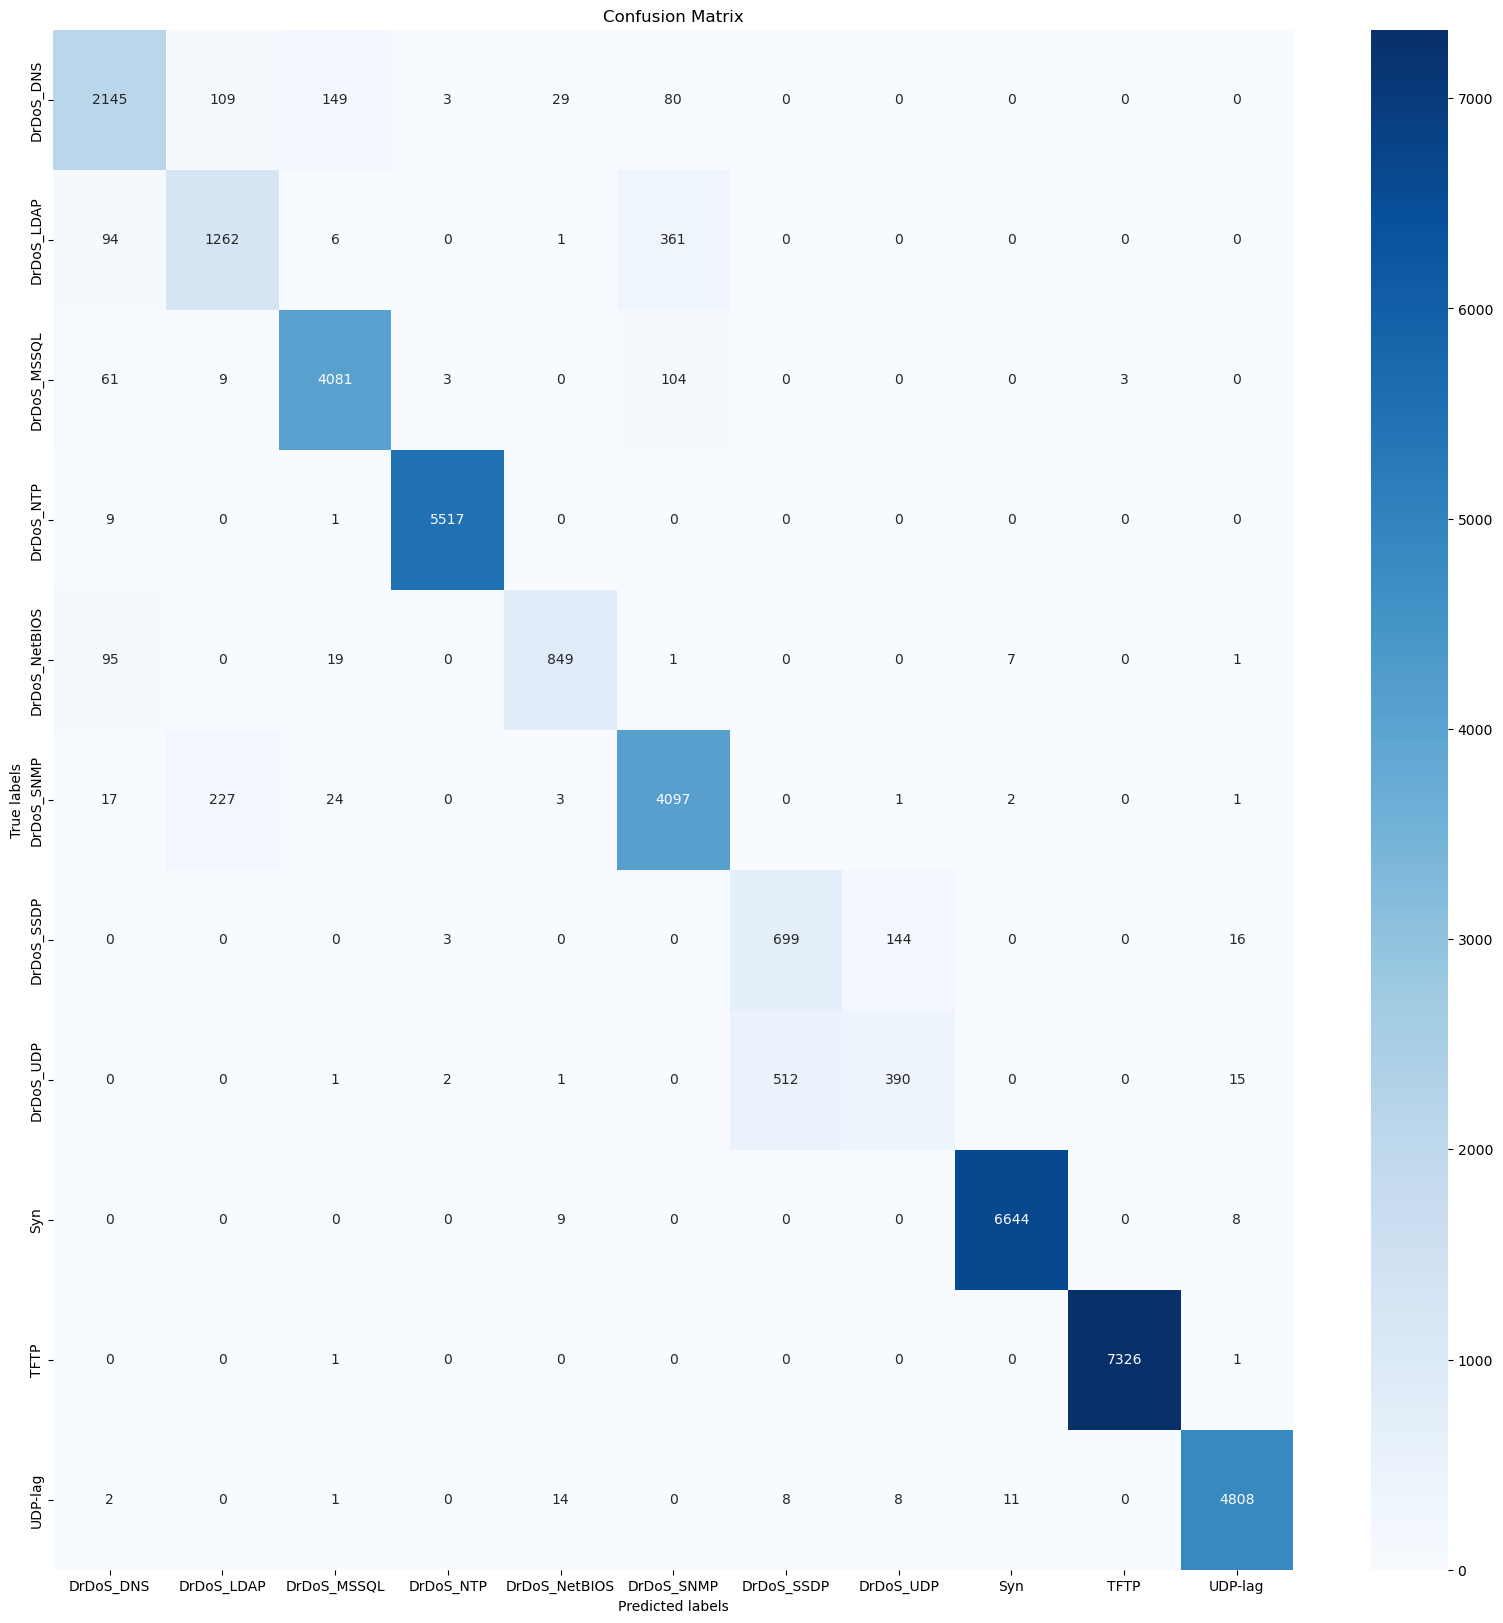

In [12]:
import seaborn as sb    

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names) 
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(20, 20)


plt.show()

# Bi-LSTM Model

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,BatchNormalization, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam



# Extract the features and label
features = df.drop("Label", axis=1).values
labels = df["Label"].values

# Encode the labels to numeric values
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

# Define the number of folds
n_splits = 2

# Initialize lists to store results
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []
history_Array=[]


# Define the Bi-LSTM model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(features.shape[1], 1)))
model.add(Bidirectional(LSTM(units=64, activation='tanh')))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=labels.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Split the data into training and testing sets
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(features,labels.argmax(1)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Reshape the data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Train the model
    history = model.fit(X_train, y_train, epochs=1, batch_size=256, validation_data=(X_test, y_test), verbose=1)

    history_Array.append(history)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train, y_train)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

print("Average Training Accuracy: {}".format(np.mean(train_acc_list)))
print("Average Training Loss: {}".format(np.mean(train_loss_list)))
print("Average Testing Accuracy: {}".format(np.mean(test_acc_list)))
print("Average Testing Loss: {}".format(np.mean(test_loss_list)))

3125/3125 [==============================] - 34s 11ms/step - loss: 0.3447 - accuracy: 0.8741
Average Training Accuracy: 0.870503157377243
Average Training Loss: 0.377777099609375
Average Testing Accuracy: 0.8711832463741302
Average Testing Loss: 0.3778577744960785


In [6]:
from keras.models import load_model

# assume that you have already defined and trained your model

# save the model to an HDF5 file with a .h5 extension
model.save('bilstm_model.h5')

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 42, 64)            128       
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 12)                204       
                                                                 
 dense_6 (Dense)             (None, 11)                143       
                                                      

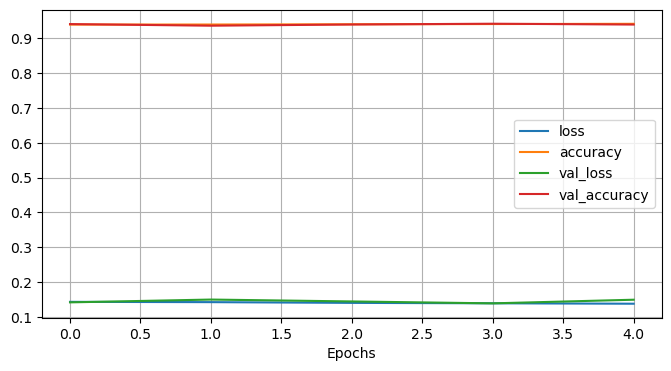

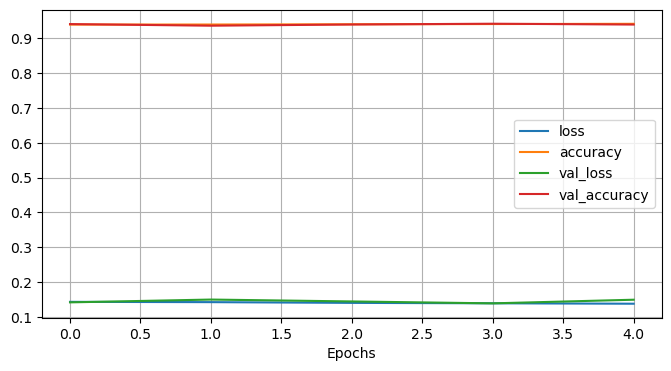

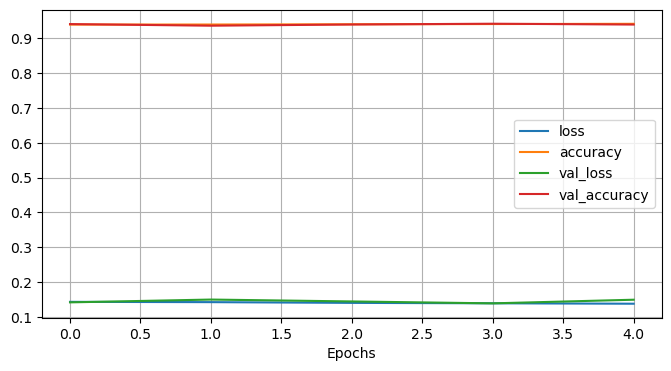

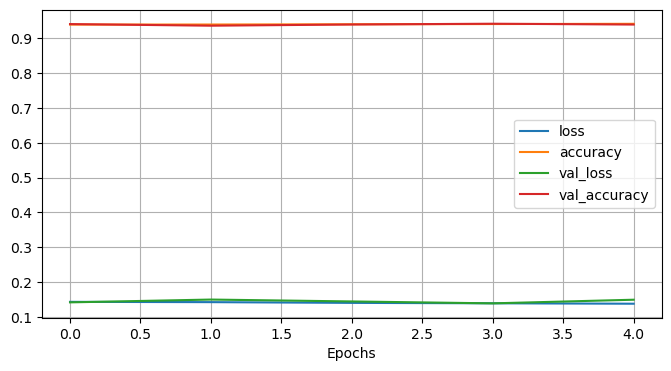

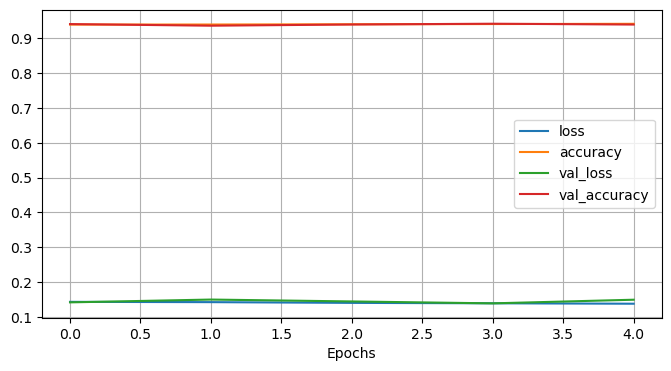

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

#pd.DataFrame(history_Array[len(history_Array)-1].history).plot(figsize=(8,4))
for i in range(5):
    pd.DataFrame(history_Array[3].history).plot(figsize=(8,4))
    plt.grid(True)
    plt.gca()
    plt.xlabel('Epochs')
    plt.show()

In [17]:
import joblib
joblib.dump(value = model, filename = '/kaggle/working/Bi-LSTMModel.pkl')

['/kaggle/working/Bi-LSTMModel.pkl']

In [4]:
import joblib
model = joblib.load('/kaggle/input/trained-models/Trained_Models/Bi-LSTMModel.pkl')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop("Label", axis=1).values
y = df["Label"].values
class_names = np.unique(y)
lb = LabelEncoder()
y = lb.fit_transform(y)
print(np.unique(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [6]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
y_classes

1250/1250 [==============================] - 14s 10ms/step


array([10, 10,  7, ...,  5,  4, 10])

In [7]:
import tensorflow as tf

confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

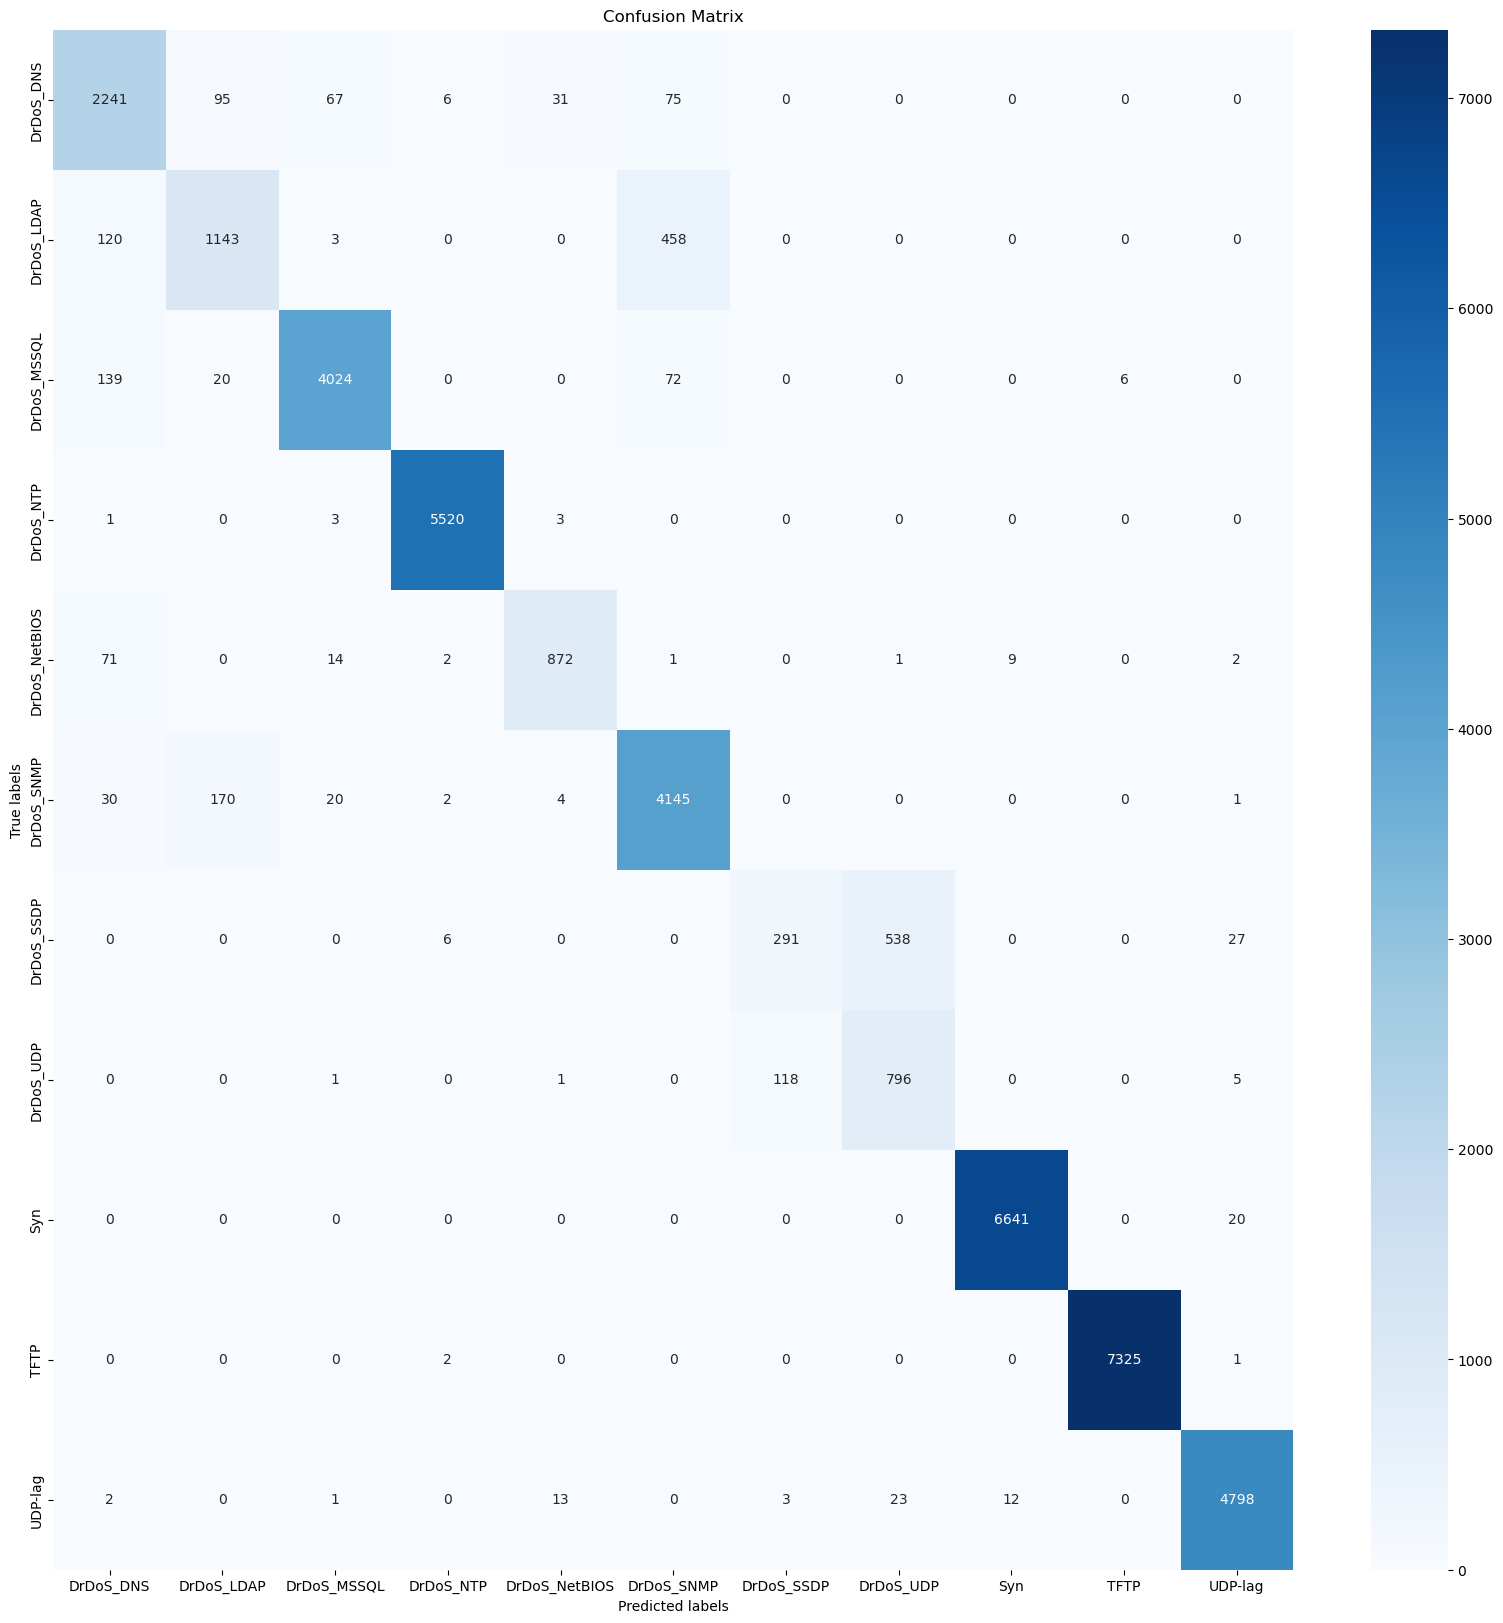

In [9]:
import seaborn as sb    
import matplotlib.pyplot as plt

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names) 
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(20, 20)


plt.show()

# Ensemble Model

In [49]:
import joblib
lstm_model = joblib.load('/kaggle/input/trained-models/Trained_Models/LSTMModel.pkl')
bilstm_model = joblib.load('/kaggle/input/trained-models/Trained_Models/Bi-LSTMModel.pkl')

gru_model = joblib.load('/kaggle/input/trained-models/Trained_Models/GRUModel.pkl')
bigru_model = joblib.load('/kaggle/input/trained-models/Trained_Models/Bi-GRUModel.pkl')

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop("Label", axis=1).values
y = df["Label"].values
class_names = np.unique(y)
lb = LabelEncoder()
y = lb.fit_transform(y)
print(np.unique(y))


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # X_test will be replaced as X

[ 0  1  2  3  4  5  6  7  8  9 10]


In [28]:
from sklearn.metrics import accuracy_score

lstm_prediction = lstm_model.predict(X_test)
lstm_y_classes = lstm_prediction.argmax(axis=-1)

bilstm_prediction = bilstm_model.predict(X_test)
bilstm_y_classes = lstm_prediction.argmax(axis=-1)

gru_prediction = gru_model.predict(X_test)
gru_y_classes = gru_prediction.argmax(axis=-1)

bigru_prediction = bigru_model.predict(X_test)
bigru_y_classes = bigru_prediction.argmax(axis=-1)

lstm_accuracy = accuracy_score(y_test, lstm_y_classes)
bilstm_accuracy = accuracy_score(y_test, bilstm_y_classes)
gru_accuracy = accuracy_score(y_test, gru_y_classes)
bigru_accuracy = accuracy_score(y_test, bigru_y_classes)


1250/1250 [==============================] - 20s 16ms/step


In [29]:
from sklearn.metrics import accuracy_score
models = [lstm_model, bilstm_model, gru_model, bigru_model]

preds = [model.predict(X_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)


1250/1250 [==============================] - 19s 15ms/step


In [31]:
print("LSTM Accuracy : ",lstm_accuracy)
print("BiLSTM Accuracy : ",bilstm_accuracy)
print("GRU Accuracy : ",gru_accuracy)
print("BiGRU Accuracy : ",bigru_accuracy)
print("Ensembled Accuracy : ",ensemble_accuracy)

LSTM Accuracy :  0.9453181647705963
BiLSTM Accuracy :  0.9453181647705963
GRU Accuracy :  0.9445430678834854
BiGRU Accuracy :  0.945568196024503
Ensembled Accuracy :  0.9483935491936492


In [164]:
import pandas as pd
import numpy as np
df = pd.read_csv('/kaggle/input/individealdatas/individual_csv_files/UDP_Dataset_Random_Undersampled.csv')

In [147]:
import joblib
lstm_model = joblib.load('/kaggle/input/trained-models/Trained_Models/LSTMModel.pkl')
bilstm_model = joblib.load('/kaggle/input/trained-models/Trained_Models/Bi-LSTMModel.pkl')

gru_model = joblib.load('/kaggle/input/trained-models/Trained_Models/GRUModel.pkl')
bigru_model = joblib.load('/kaggle/input/trained-models/Trained_Models/Bi-GRUModel.pkl')